In [11]:
import sys
from pathlib import Path
import json

import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit.library import ZZFeatureMap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from pandas import DataFrame

sys.path.extend(['/home/quic/QUIC-Projects/'])
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from classifiers.convex.svm import CvxSoftQASVM

In [19]:
# simulation setting
dir_name = 'numerical_simulation_bp4'

In [20]:
from numpy import longcomplex, longdouble
from pandas import read_csv
dir_path = Path.cwd() / dir_name
if dir_path.joinpath('grad_var_summary').exists():
    grad_var_summary = read_csv(dir_path.joinpath('grad_var_summary'), index_col=0)
    grad_var_summary.columns = grad_var_summary.columns.astype(int)
    grad_var_summary.index = grad_var_summary.index.astype(int)
grad_var_summary

,6,7,8,9,10,11,12,13
1,4.297654e-35,1.659046e-35,9.512218e-36,5.130798e-36,2.964051e-36,2.117301e-36,2.238611e-36,1.802297e-36
3,5.612280e-35,4.251340e-35,7.887214e-36,5.695035e-36,8.004646e-36,3.374257e-36,2.437534e-36,3.048321e-36
5,8.981952e-35,4.125891e-35,7.306432e-36,7.831408e-36,5.452531e-36,4.557232e-36,2.859272e-36,2.170264e-36
7,1.115610e-34,8.209276e-35,3.057414e-35,9.481537e-36,6.035458e-36,2.540956e-36,2.767231e-36,2.319985e-36
9,1.217850e-34,4.799967e-35,2.232875e-35,9.447948e-36,5.059159e-36,2.546385e-36,2.750187e-36,2.218422e-36
11,1.383402e-34,5.884649e-35,2.293060e-35,1.634031e-35,8.262785e-36,5.526234e-36,2.368217e-36,2.185009e-36
13,1.311969e-34,3.679062e-35,2.411738e-35,7.897441e-36,8.207772e-36,5.323351e-36,2.616538e-36,2.581885e-36
15,1.054917e-34,6.037339e-35,2.200913e-35,1.079774e-35,5.507073e-36,4.968609e-36,2.586822e-36,2.246342e-36
17,2.185930e-34,7.012729e-35,2.154070e-35,1.558800e-35,1.649830e-35,5.741702e-36,3.736309e-36,2.253019e-36
19,3.290406e-34,9.425020e-35,2.637668e-35,3.498835e-35,6.304411e-36,1.457989e-35,2.408842e-36,2.862094e-36


In [21]:
from pandas import DataFrame
data = {'n_qubits':[], 'n_layers':[], 'grad_var':[]}
for n_qubits in grad_var_summary.columns:
    for n_layers in grad_var_summary.index:
        data['n_qubits'].append(n_qubits)
        data['n_layers'].append(n_layers)
        data['grad_var'].append(grad_var_summary[n_qubits][n_layers])

df = DataFrame(data)
df

,n_qubits,n_layers,grad_var
0,6,1,4.297654e-35
1,6,3,5.612280e-35
2,6,5,8.981952e-35
3,6,7,1.115610e-34
4,6,9,1.217850e-34
...,...,...,...
75,13,11,2.185009e-36
76,13,13,2.581885e-36
77,13,15,2.246342e-36
78,13,17,2.253019e-36


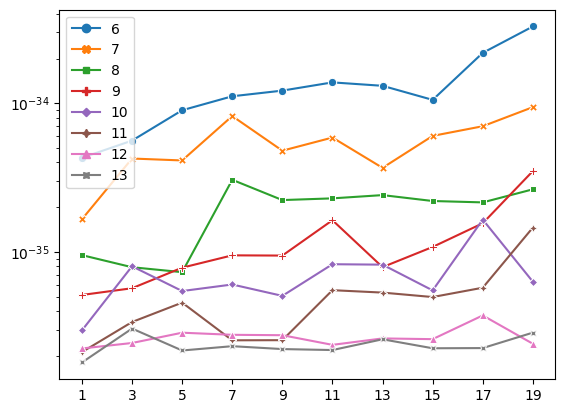

In [22]:
import seaborn as sns
sns.lineplot(data=grad_var_summary, dashes=False, markers=True)
plt.xticks(grad_var_summary.index)
plt.yscale('log')

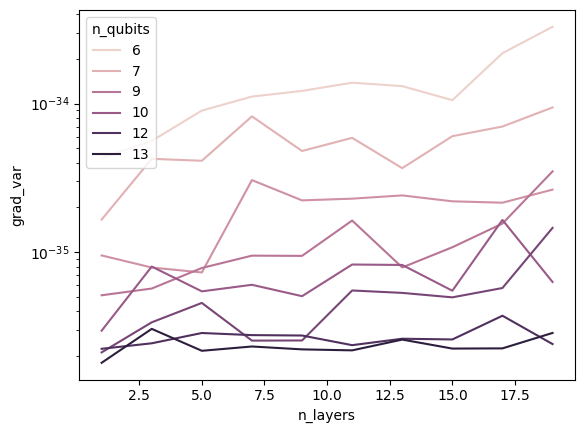

In [23]:
sns.lineplot(data=df, x='n_layers', y='grad_var', hue='n_qubits', dashes=False, markers=True)
plt.yscale('log')

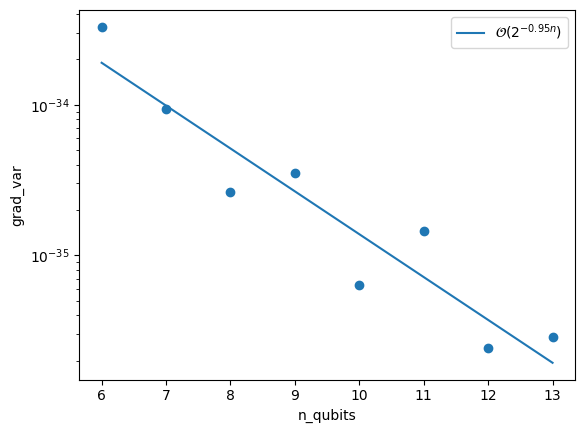

In [24]:
x = grad_var_summary.columns.to_numpy()
y = grad_var_summary.iloc[-1].to_numpy()

# a, b, c = np.polyfit(x, np.log2(y), 2)
# plt.plot(x, 2**(a*x**2+b*x+c), label=r'$\mathcal{{O}}(2^{{{:.2f}n}})$'.format(a))
a, b = np.polyfit(x, np.log2(y), 1)
plt.plot(x, 2**(a*x+b), label=r'$\mathcal{{O}}(2^{{{:.2f}n}})$'.format(a))

plt.scatter(x, y)
plt.yscale('log')

plt.xlabel('n_qubits')
plt.ylabel('grad_var')
plt.legend()

In [10]:
b

-5.216073644057325